# About 
This notebook compares methods for fitting the $\phi$ dependence of the beam spin asymmetry using the `phifitter` package.  Results are computed for measurements with systematic errors.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from phifitter import fitter
from phifitter import loss
from phifitter import physics_model

from pymc3 import autocorrplot

%matplotlib inline
plt.rc('font', size=18)
plt.rc('font', family='serif')

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_to_data = './results/phi/'
input_filename = 'sys.csv'
compression_type = None
important_cols = ['axis', 'axis_bin', 'axis_min', 'axis_max',
                 'phi', 'exp_val', 'std_dev', 'stat']

### Load Dataset 
Dropping columns which aren't used in this analysis.

In [3]:
data = pd.read_csv(path_to_data+input_filename, compression=compression_type)
data = data[important_cols]

### Setup Fitter
The fitting is setup from `phifitter` package.

In [4]:
model = physics_model.BeamSpinAsymmetryModel()

# Parameter bounds, these are physically motivated
bounds = [[-1, 1], [-1, 1], [-1, 1]]
x0 = [0.0, 0.0, 0.0]

fitters = {}
fitters['single'] = fitter.SingleFitter(model=model, 
                                        loss_function=loss.chi2, 
                                        bounds=bounds)
fitters['regularized'] = fitter.SingleRegularizedFitter(model=model, 
                                        loss_function=loss.chi2, 
                                        bounds=bounds, 
                                        penalty=0.05)
fitters['replica'] = fitter.ReplicaFitter(model=model, 
                                        loss_function=loss.chi2, 
                                        bounds=bounds,
                                         n_replicas=100, 
                                         n_cores=4)

# flat prior 
def prior(p):
    return 1.0

fitters['bayesian-vegas'] = fitter.BayesianVegasFitter(model=model,
                                                      likelihood=loss.likelihood,
                                                      prior=prior,
                                                      bounds=bounds)

fitters['bayesian-mcmc'] = fitter.BayesianMCMCFitter(model=model,
                                                      likelihood=loss.likelihood,
                                                      prior=prior,
                                                      bounds=bounds,
                                                    n_iterations=6000)

### Split by bin, start fitting
Here we go.  To start, let's just apply our methods to the z-axis.

In [5]:
data.query('axis == "z"', inplace=True)

results = {}
for key in fitters.keys():
    results[key] = []
    
for axis_bin in np.unique(data.axis_bin.values):
    print('Starting fit for %d' % axis_bin)
    
    # subset of total data for this bin 
    d = data.query('axis_bin == %d' % axis_bin)
    
    # error = np.sqrt(d.stat**2 + d.std_dev**2)
    error = d.stat
    for name in fitters.keys():
        results[name].append(fitters[name].fit(d.phi.values, d.exp_val.values, error))

Starting fit for 0
Starting fit for 1
Starting fit for 2
Starting fit for 3
Starting fit for 4
Starting fit for 5
Starting fit for 6
Starting fit for 7
Starting fit for 8
Starting fit for 9


In [6]:
for name in results.keys():
    for i, b in enumerate(results[name]):
        print('Method %s, bin %d, loss %.3f, quality %.3f' % 
              (name, i, b.loss, b.quality))

Method bayesian-mcmc, bin 0, loss 1786311.856, quality 0.000
Method bayesian-mcmc, bin 1, loss 1979814.766, quality 0.000
Method bayesian-mcmc, bin 2, loss 2031929.782, quality 0.000
Method bayesian-mcmc, bin 3, loss 2058161.191, quality 0.000
Method bayesian-mcmc, bin 4, loss 2070521.569, quality 0.000
Method bayesian-mcmc, bin 5, loss 2038732.262, quality 0.000
Method bayesian-mcmc, bin 6, loss 2014102.450, quality 0.000
Method bayesian-mcmc, bin 7, loss 1965214.178, quality 0.000
Method bayesian-mcmc, bin 8, loss 1897792.905, quality 0.000
Method bayesian-mcmc, bin 9, loss 1722018.144, quality 0.000
Method regularized, bin 0, loss 12.030, quality 0.443
Method regularized, bin 1, loss 6.153, quality 0.908
Method regularized, bin 2, loss 17.080, quality 0.147
Method regularized, bin 3, loss 10.627, quality 0.561
Method regularized, bin 4, loss 38.689, quality 0.000
Method regularized, bin 5, loss 8.216, quality 0.768
Method regularized, bin 6, loss 12.274, quality 0.424
Method regular

### Quality Control
Here we need to check convergence metrics for the more complicated methods.

In [7]:
# plot auto-correlation for mcmc

In [8]:
def plot_mcmc_trace(results, bin_index):

    fig = plt.figure(figsize=(30, 7))
    
    ax = fig.add_subplot(131)
    ax.plot(results[bin_index].samples[:,0])    
    ax = fig.add_subplot(132)
    ax.plot(results[bin_index].samples[:,1])    
    ax = fig.add_subplot(133)
    ax.plot(results[bin_index].samples[:,2])
    
    fig.tight_layout()

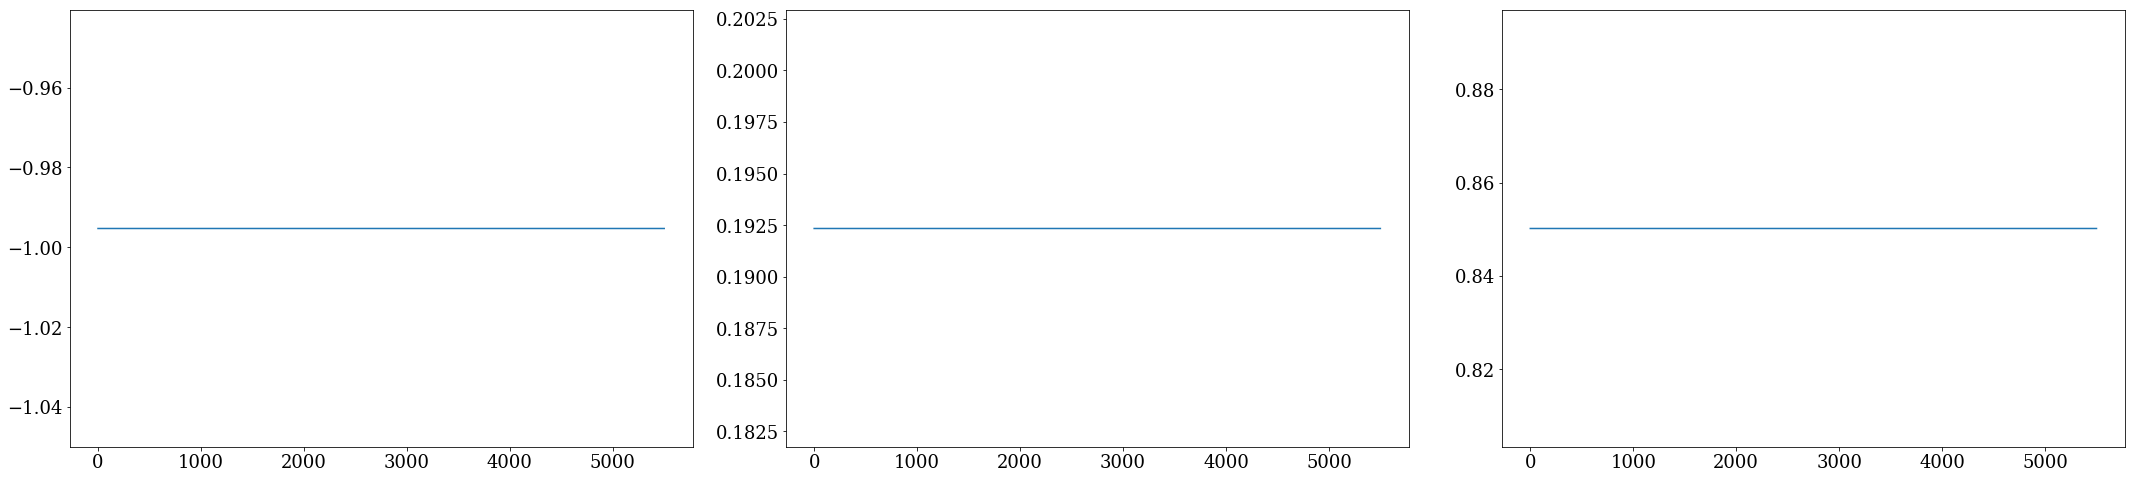

In [9]:
plot_mcmc_trace(results['bayesian-mcmc'], 2)

### Analysis of Results
Build the z-dependent results for each method and compare visually for each parameter.

In [10]:
x    = np.unique( data.axis_min + 0.5 * (data.axis_max - data.axis_min) )
y    = np.zeros( (len(fitters.keys()), len(x), 3) )
yerr = np.zeros( (len(fitters.keys()), len(x), 3) )

# Indexing Scheme 
# [method, bin, parameter]
for i, name in enumerate(results.keys()):
    for j, r in enumerate(results[name]):
        y[i,j,0] = results[name][j].fit_parameters[0] 
        y[i,j,1] = results[name][j].fit_parameters[1] 
        y[i,j,2] = results[name][j].fit_parameters[2] 
        
        yerr[i,j,0] = results[name][j].fit_errors[0] 
        yerr[i,j,1] = results[name][j].fit_errors[1] 
        yerr[i,j,2] = results[name][j].fit_errors[2] 

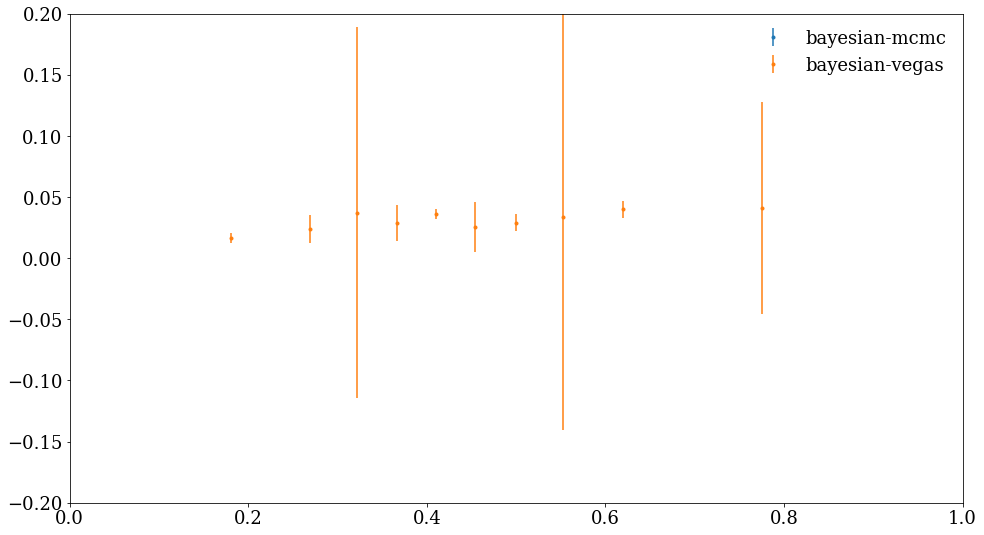

In [11]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

#for index, name in enumerate(results.keys()):
for index, name in enumerate(['bayesian-mcmc', 'bayesian-vegas']):
    ax.errorbar(x, y[index,:,0], yerr[index,:,0], 
                 linestyle='', marker='.', label=name)

ax.set_ylim([-0.2, 0.2])
ax.set_xlim([0, 1])
ax.legend(frameon=False)

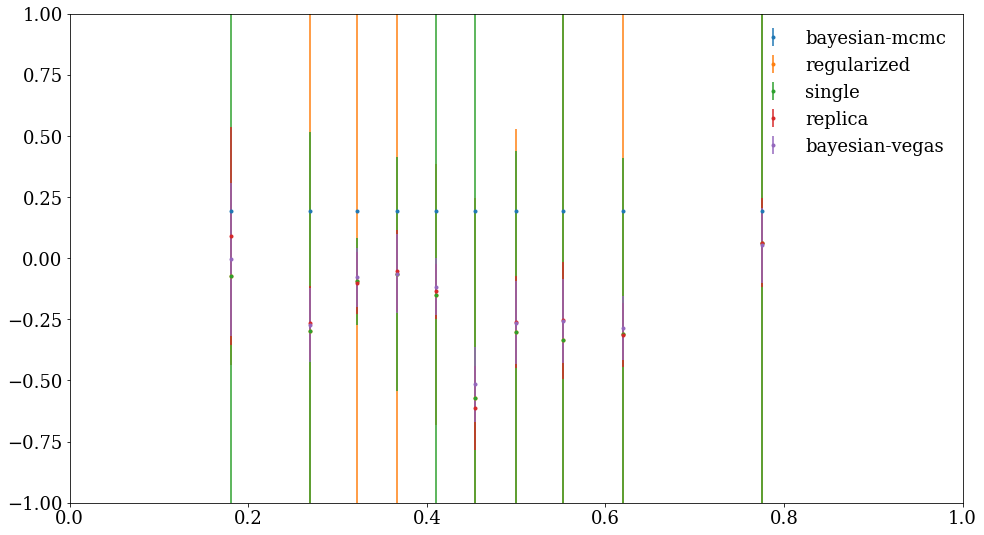

In [12]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

for index, name in enumerate(results.keys()):
    ax.errorbar(x, y[index,:,1], yerr[index,:,1], 
                 linestyle='', marker='.', label=name)

ax.set_ylim([-1, 1])
ax.set_xlim([0, 1])
ax.legend(frameon=False)

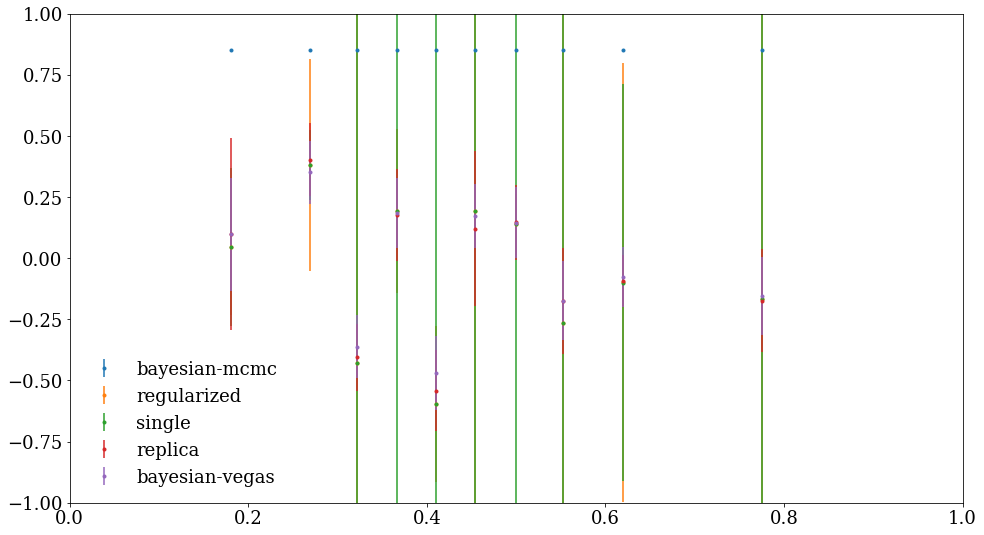

In [13]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

for index, name in enumerate(results.keys()):
    ax.errorbar(x, y[index,:,2], yerr[index,:,2], 
                 linestyle='', marker='.', label=name)

ax.set_ylim([-1, 1])
ax.set_xlim([0, 1])
ax.legend(frameon=False)